In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
def eval_model(dt_classifier,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_predict = dt_classifier.predict(X_train)
    print("Train Accuracy :", accuracy_score(y_train,y_predict))
    print("Train Confusion Matrix :")
    print(confusion_matrix(y_train, y_predict))
    print("Train Recall :")
    print(recall_score(y_train, y_predict))
    print("-"*50)
    #result on test:
    y_predict = dt_classifier.predict(X_test)
    print("Test Accuracy :", accuracy_score(y_test, y_predict))
    print("Test Confusion Matrix :")
    print(confusion_matrix(y_test, y_predict))
    print("Test Recall :")
    print(recall_score(y_test, y_predict))

NameError: name 'X_train' is not defined

In [ ]:
getdata().shape

In [45]:
def getdata(remove_free = False):
    data = pd.read_csv('Steam/steam.csv')
#     print(data['achievements'].describe())
    data['owners'] = data['owners'].str.split('-', expand=True).astype(int).mean(axis=1)
    row_1,col_1 = data.shape
    
    # 1 if achivement else 0
#     data['achievements'] = data['achievements'].apply(lambda x: 1 if x > 0 else 0)

    # remove genres
    str_to_remove = ['Photo Editing', 'Audio Production', 'Accounting', 'Software Training', 'Web Publishing', 'Utilities', 'Documentary', 'Education', 'Game Development', 'Design & Illustration', 'Tutorial', 'Video Production', 'Animation & Modeling']
    data = data[~data['genres'].str.contains('|'.join(str_to_remove))]
    
    if remove_free == True:
        data = data[data['price'] != 0]
        print('===Free Games Removed===')
    else:
        print('===With Free Games===')
    # remove top 6 due to anomalies
    top6_price = data['price'].nlargest(6)
    data = data[~data['price'].isin(top6_price)]

#     print("Top 10 by price:")
#     print(data.nlargest(10, 'price'))
    data.reset_index(drop=True, inplace=True)
    row_2,col_2 = data.shape
    print("rows filtered: ", row_2-row_1)
    print("Total Rows : ", row_2)
    print(list(data.keys()))
    
    # Select numeric columns
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    # Standardize features for better performance
    X = StandardScaler().fit_transform(data[numeric_columns])

    # Calculate Z-score
    z_scores = np.abs(stats.zscore(X))

    # Define a threshold for outliers (e.g., data points with Z-score > 3)
    z_threshold = 3
    outliers_z = np.where(np.any(z_scores > z_threshold, axis=1))

    # Perform DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(X)

    # Identify outliers (noise points) in DBSCAN
    outliers_dbscan = np.where(dbscan.labels_ == -1)

    # Remove outliers detected by Z-score
    data_filtered = data.drop(outliers_z[0])
    print("Number of outliers removed:", len(outliers_z[0]))
    print("Data shape after removing outliers:", data_filtered.shape)
    
    return data_filtered

getdata().describe().T

===With Free Games===
rows filtered:  -234
Total Rows :  26841
['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']
Number of outliers removed: 1820
Data shape after removing outliers: (25021, 18)


,count,mean,std,min,25%,50%,75%,max
appid,25021.0,596969.498901,249040.199671,280.0,403830.00,598590.00,797550.00,1069460.00
english,25021.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.00
required_age,25021.0,0.004117,0.153376,0.0,0.00,0.00,0.00,7.00
achievements,25021.0,17.575357,46.455133,0.0,0.00,7.00,22.00,1100.00
positive_ratings,25021.0,409.684185,2127.318790,0.0,6.00,23.00,108.00,53710.00
negative_ratings,25021.0,88.290596,398.494529,0.0,2.00,8.00,37.00,11583.00
average_playtime,25021.0,68.605371,271.124136,0.0,0.00,0.00,0.00,5647.00
median_playtime,25021.0,70.843052,286.747903,0.0,0.00,0.00,0.00,7099.00
owners,25021.0,80377.283082,297617.359480,10000.0,10000.00,10000.00,35000.00,3500000.00
price,25021.0,5.330540,4.861201,0.0,1.69,3.99,7.19,24.99


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

# Load the dataset
data = getdata()

# Convert release_date to datetime and extract the year
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data['release_date'].dt.year

# MultiLabelBinarizer for multiple value columns
multi_val_columns = ['platforms', 'categories', 'genres', 'steamspy_tags']

for col in multi_val_columns:
    data[col] = data[col].apply(lambda x: x.split(';'))
    multi_label_binarizer = MultiLabelBinarizer()  # Create a new MultiLabelBinarizer for each column
    one_hot_encoded = multi_label_binarizer.fit_transform(data[col])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=[f"{col}_{category}" for category in multi_label_binarizer.classes_])
    data = pd.concat([data.reset_index(drop=True), one_hot_encoded_df.reset_index(drop=True)], axis=1)

# Drop the original columns that have been one-hot encoded
data.drop(['platforms', 'categories', 'genres', 'steamspy_tags'], axis=1, inplace=True)

# Calculate the midpoint of the owners' range
data['owners_midpoint_log'] = np.log1p(data['owners'])

# Drop the original owners column
data.drop(['owners'], axis=1, inplace=True)

# Standardize numerical features
num_features = ['achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

print(data.shape)
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)


===With Free Games===
rows filtered:  -234
Total Rows :  26841
['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']
Number of outliers removed: 1820
Data shape after removing outliers: (25021, 18)
(25021, 389)


In [51]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from joblib import Parallel, delayed
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def perform_rfe(X, y, estimator, n_jobs=-1):
    rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=n_jobs)
    rfecv.fit(X, y)
    return rfecv
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2


In [52]:
def rfe_single_target(target, train_data, test_data):
    print(f"\nPerforming RFE for {target}...")

    X = train_data.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements', 'owners_midpoint_log', target], axis=1)
    y = train_data[target]

    # Create a list of regression models to test
    regression_models = [
        ('Ridge Regression', Ridge(alpha=1.0)),
        ('Lasso Regression', Lasso(alpha=0.1)),
        ('Elastic Net Regression', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
        ('Random Forest Regressor', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('Gradient Boosting Regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]

    for model_name, model in regression_models:
        mse, r2 = fit_and_evaluate_model(model, X, y, test_data.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements', 'owners_midpoint_log', target], axis=1), test_data[target])
        print(f"{model_name}:")
        print(f"Mean Squared Error on test data: {mse}")
        print(f"R^2 score on test data: {r2}\n")
# print(train_data.keys())

In [53]:

test = train_data.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements'], axis=1)
test = test.drop(['positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'price', 'release_year'], axis=1)
print(test.keys())
for item in test.keys():
    print(item)

Index(['platforms_linux', 'platforms_mac', 'platforms_windows',
       'categories_Captions available', 'categories_Co-op',
       'categories_Commentary available',
       'categories_Cross-Platform Multiplayer',
       'categories_Full controller support', 'categories_In-App Purchases',
       'categories_Includes Source SDK',
       ...
       'steamspy_tags_Warhammer 40K', 'steamspy_tags_Werewolves',
       'steamspy_tags_Western', 'steamspy_tags_Word Game',
       'steamspy_tags_World War I', 'steamspy_tags_World War II',
       'steamspy_tags_Wrestling', 'steamspy_tags_Zombies',
       'steamspy_tags_e-sports', 'owners_midpoint_log'],
      dtype='object', length=375)
platforms_linux
platforms_mac
platforms_windows
categories_Captions available
categories_Co-op
categories_Commentary available
categories_Cross-Platform Multiplayer
categories_Full controller support
categories_In-App Purchases
categories_Includes Source SDK
categories_Includes level editor
categories_Local Co-op
ca

In [55]:
target_features = test.keys()
print(target_features)
for target in target_features:
    rfe_single_target(target, train_data, test_data)


Index(['platforms_linux', 'platforms_mac', 'platforms_windows',
       'categories_Captions available', 'categories_Co-op',
       'categories_Commentary available',
       'categories_Cross-Platform Multiplayer',
       'categories_Full controller support', 'categories_In-App Purchases',
       'categories_Includes Source SDK',
       ...
       'steamspy_tags_Warhammer 40K', 'steamspy_tags_Werewolves',
       'steamspy_tags_Western', 'steamspy_tags_Word Game',
       'steamspy_tags_World War I', 'steamspy_tags_World War II',
       'steamspy_tags_Wrestling', 'steamspy_tags_Zombies',
       'steamspy_tags_e-sports', 'owners_midpoint_log'],
      dtype='object', length=375)

Performing RFE for platforms_linux...
Ridge Regression:
Mean Squared Error on test data: 0.09193064549365586
R^2 score on test data: 0.4304215154693185

Lasso Regression:
Mean Squared Error on test data: 0.1476396023088847
R^2 score on test data: 0.08526323851810358

Elastic Net Regression:
Mean Squared Error on te

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0005039829393665818
R^2 score on test data: 0.05364576692097345


Performing RFE for categories_Includes level editor...
Ridge Regression:
Mean Squared Error on test data: 0.024591279958292352
R^2 score on test data: 0.25059602921045

Lasso Regression:
Mean Squared Error on test data: 0.03283641433408946
R^2 score on test data: -0.0006693157165100772

Elastic Net Regression:
Mean Squared Error on test data: 0.03283641433408946
R^2 score on test data: -0.0006693157165100772

Decision Tree Regressor:
Mean Squared Error on test data: 0.04876282136672439
R^2 score on test data: -0.486016670181586

Random Forest Regressor:
Mean Squared Error on test data: 0.025139717608180207
R^2 score on test data: 0.233882732738956

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.023722906885493705
R^2 score on test data: 0.27705915882329424


Performing RFE for categories_Local Co-op...
Ridge Regression:
Mean Squared Error on

Decision Tree Regressor:
Mean Squared Error on test data: 0.06833621952844013
R^2 score on test data: 0.08189139730395667

Random Forest Regressor:
Mean Squared Error on test data: 0.03433153057146664
R^2 score on test data: 0.5387501126212034

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.03291717054568594
R^2 score on test data: 0.5577522774459378


Performing RFE for categories_Single-player...
Ridge Regression:
Mean Squared Error on test data: 0.02970461581920189
R^2 score on test data: 0.3032584928048139

Lasso Regression:
Mean Squared Error on test data: 0.04263412884421762
R^2 score on test data: -1.1828790319690086e-05

Elastic Net Regression:
Mean Squared Error on test data: 0.04263412884421762
R^2 score on test data: -1.1828790319690086e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.05394964699613694
R^2 score on test data: -0.26542482789621347

Random Forest Regressor:
Mean Squared Error on test data: 0.02823203676568536
R^2 score on test 

Elastic Net Regression:
Mean Squared Error on test data: 0.0025249835828651413
R^2 score on test data: -0.00016569343623884514

Decision Tree Regressor:
Mean Squared Error on test data: 0.004795524177434394
R^2 score on test data: -0.8995445344129549

Random Forest Regressor:
Mean Squared Error on test data: 0.00238512055414946
R^2 score on test data: 0.05523514324673906

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.002539394989880125
R^2 score on test data: -0.005874164171790097


Performing RFE for genres_Action...
Ridge Regression:
Mean Squared Error on test data: 0.044863987327743195
R^2 score on test data: 0.8182521724241544

Lasso Regression:
Mean Squared Error on test data: 0.09683451362160193
R^2 score on test data: 0.6077151512075578

Elastic Net Regression:
Mean Squared Error on test data: 0.08056411028966065
R^2 score on test data: 0.6736279386234569

Decision Tree Regressor:
Mean Squared Error on test data: 0.07446383375516184
R^2 score on test data: 0.69

Elastic Net Regression:
Mean Squared Error on test data: 0.039109543240207184
R^2 score on test data: -0.00023336703848064744

Decision Tree Regressor:
Mean Squared Error on test data: 0.021180231783668575
R^2 score on test data: 0.4583118902331105

Random Forest Regressor:
Mean Squared Error on test data: 0.010597152145960066
R^2 score on test data: 0.7289759916941299

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.009474983534483625
R^2 score on test data: 0.7576756490066204


Performing RFE for genres_Sexual Content...
Ridge Regression:
Mean Squared Error on test data: 0.004662980678303055
R^2 score on test data: 0.4214464260449622

Lasso Regression:
Mean Squared Error on test data: 0.008059721821151914
R^2 score on test data: -3.99761019842515e-08

Elastic Net Regression:
Mean Squared Error on test data: 0.008059721821151914
R^2 score on test data: -3.99761019842515e-08

Decision Tree Regressor:
Mean Squared Error on test data: 0.005994405221792993
R^2 score on tes

Elastic Net Regression:
Mean Squared Error on test data: 3.2600878953601498e-09
R^2 score on test data: 0.0

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: 0.0

Random Forest Regressor:
Mean Squared Error on test data: 1.5172505661382712e-05
R^2 score on test data: 0.0

Gradient Boosting Regressor:
Mean Squared Error on test data: 3.8016758090070695e-05
R^2 score on test data: 0.0


Performing RFE for steamspy_tags_3D Platformer...
Ridge Regression:
Mean Squared Error on test data: 0.000680957285290567
R^2 score on test data: -0.02307067927104467

Lasso Regression:
Mean Squared Error on test data: 0.0006672276943770142
R^2 score on test data: -0.0024433327319022258

Elastic Net Regression:
Mean Squared Error on test data: 0.0006672276943770142
R^2 score on test data: -0.0024433327319022258

Decision Tree Regressor:
Mean Squared Error on test data: 0.002364459837485014
R^2 score on test data: -2.5523660357238067

Random Forest Reg

Elastic Net Regression:
Mean Squared Error on test data: 0.0009315993240026634
R^2 score on test data: -6.20100070447549e-06

Decision Tree Regressor:
Mean Squared Error on test data: 0.0009324630345011322
R^2 score on test data: -0.0009333333333334526

Random Forest Regressor:
Mean Squared Error on test data: 0.0010055814573065138
R^2 score on test data: -0.07942080571428578

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0009075846940208919
R^2 score on test data: 0.02577181136766904


Performing RFE for steamspy_tags_Aliens...
Ridge Regression:
Mean Squared Error on test data: 0.00013623670653773338
R^2 score on test data: -0.022865210835676164

Lasso Regression:
Mean Squared Error on test data: 0.0001332959568188039
R^2 score on test data: -0.0007860615541670501

Elastic Net Regression:
Mean Squared Error on test data: 0.0001332959568188039
R^2 score on test data: -0.0007860615541670501

Decision Tree Regressor:
Mean Squared Error on test data: 0.000399627014786199

C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642



C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Elastic Net Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Random Forest Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642


Performing RFE for steamspy_tags_Anime...
Ridge Regression:
Mean Squared Error on test data: 0.013798911245928731
R^2 score on test data: 0.24602152513044184

Lasso Regression:
Mean Squared Error on test data: 0.018310493588415494
R^2 score on test data: -0.0004932841332401239

Elastic Net Regression:
Mean Squared Error on test data: 0.018310493588415494
R^2 score on test data: -0.0004932841332401239

Decision Tree Regressor:
Mean Squared Error on test data: 0.025176501931530

Elastic Net Regression:
Mean Squared Error on test data: 0.0009315939047090915
R^2 score on test data: -3.8377108935172544e-07

Decision Tree Regressor:
Mean Squared Error on test data: 0.0015985080591447982
R^2 score on test data: -0.7158857142857145

Random Forest Regressor:
Mean Squared Error on test data: 0.0008928466764353271
R^2 score on test data: 0.04159203428571412

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0008711129574489999
R^2 score on test data: 0.06492164949384172


Performing RFE for steamspy_tags_Beat 'em up...
Ridge Regression:
Mean Squared Error on test data: 0.0016985969373943097
R^2 score on test data: 0.01742405577686512

Lasso Regression:
Mean Squared Error on test data: 0.001728718573586777
R^2 score on test data: -2.0448864623823226e-07

Elastic Net Regression:
Mean Squared Error on test data: 0.001728718573586777
R^2 score on test data: -2.0448864623823226e-07

Decision Tree Regressor:
Mean Squared Error on test data: 0.003596643133075796

Elastic Net Regression:
Mean Squared Error on test data: 0.0001331927105690792
R^2 score on test data: -1.0888697479227716e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.0002664180098574664
R^2 score on test data: -1.0002664535038641

Random Forest Regressor:
Mean Squared Error on test data: 0.00015758625283069134
R^2 score on test data: -0.18315760724753538

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.00015290037577684462
R^2 score on test data: -0.1479760417029703


Performing RFE for steamspy_tags_Card Game...
Ridge Regression:
Mean Squared Error on test data: 0.0056456994902057975
R^2 score on test data: 0.07296588226947465

Lasso Regression:
Mean Squared Error on test data: 0.0060902120855650076
R^2 score on test data: -2.3893820061848814e-05

Elastic Net Regression:
Mean Squared Error on test data: 0.0060902120855650076
R^2 score on test data: -2.3893820061848814e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.014786199547089

C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642



C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Elastic Net Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Random Forest Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642


Performing RFE for steamspy_tags_City Builder...
Ridge Regression:
Mean Squared Error on test data: 0.0023182829505969636
R^2 score on test data: 0.030823361101790403

Lasso Regression:
Mean Squared Error on test data: 0.0023920259390946097
R^2 score on test data: -5.482166048897952e-06

Elastic Net Regression:
Mean Squared Error on test data: 0.0023920259390946097
R^2 score on test data: -5.482166048897952e-06

Decision Tree Regressor:
Mean Squared Error on test data: 0.0053

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0005780122017199358
R^2 score on test data: 0.13159408289723096


Performing RFE for steamspy_tags_Controller...
Ridge Regression:
Mean Squared Error on test data: 3.778958918345145e-07
R^2 score on test data: 0.0

Lasso Regression:
Mean Squared Error on test data: 1.3040351581440599e-08
R^2 score on test data: 0.0

Elastic Net Regression:
Mean Squared Error on test data: 1.3040351581440599e-08
R^2 score on test data: 0.0

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: 0.0

Random Forest Regressor:
Mean Squared Error on test data: 2.157985879845478e-06
R^2 score on test data: 0.0

Gradient Boosting Regressor:
Mean Squared Error on test data: 1.269161668485969e-05
R^2 score on test data: 0.0


Performing RFE for steamspy_tags_Conversation...
Ridge Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642



C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642



C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Elastic Net Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Random Forest Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642


Performing RFE for steamspy_tags_Crafting...
Ridge Regression:
Mean Squared Error on test data: 0.0005470049614819719
R^2 score on test data: -0.02713885804210414

Lasso Regression:
Mean Squared Error on test data: 0.000532743788367217
R^2 score on test data: -0.00035993262295552775

Elastic Net Regression:
Mean Squared Error on test data: 0.000532743788367217
R^2 score on test data: -0.00035993262295552775

Decision Tree Regressor:
Mean Squared Error on test data: 0.00173171

C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso Regression:
Mean Squared Error on test data: 0.0002664180098574664
R^2 score on test data: -0.00026648900732895164



C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Elastic Net Regression:
Mean Squared Error on test data: 0.0002664180098574664
R^2 score on test data: -0.00026648900732895164

Decision Tree Regressor:
Mean Squared Error on test data: 0.0002664180098574664
R^2 score on test data: -0.00026648900732895164

Random Forest Regressor:
Mean Squared Error on test data: 0.0002664180098574664
R^2 score on test data: -0.00026648900732895164

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0002664180098574664
R^2 score on test data: -0.00026648900732895164


Performing RFE for steamspy_tags_Dark Humor...
Ridge Regression:
Mean Squared Error on test data: 0.00027161705930824146
R^2 score on test data: -0.01978632155575344

Lasso Regression:
Mean Squared Error on test data: 0.0002663702033414316
R^2 score on test data: -8.699943013668054e-05

Elastic Net Regression:
Mean Squared Error on test data: 0.0002663702033414316
R^2 score on test data: -8.699943013668054e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.00039

Elastic Net Regression:
Mean Squared Error on test data: 0.0002663560803471002
R^2 score on test data: -3.397464415599849e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.00039962701478619956
R^2 score on test data: -0.5003997335109938

Random Forest Regressor:
Mean Squared Error on test data: 0.0003022778739842813
R^2 score on test data: -0.13490235842771559

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.00026890478339137655
R^2 score on test data: -0.009603080903092698


Performing RFE for steamspy_tags_Dragons...
Ridge Regression:
Mean Squared Error on test data: 0.0001451229309026465
R^2 score on test data: -0.08958298455132674

Lasso Regression:
Mean Squared Error on test data: 0.00013333616659612092
R^2 score on test data: -0.0010879565676202851

Elastic Net Regression:
Mean Squared Error on test data: 0.00013333616659612092
R^2 score on test data: -0.0010879565676202851

Decision Tree Regressor:
Mean Squared Error on test data: 0.000532836019714

Elastic Net Regression:
Mean Squared Error on test data: 5.2161406325762396e-08
R^2 score on test data: 0.0

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: 0.0

Random Forest Regressor:
Mean Squared Error on test data: 4.874117490342347e-05
R^2 score on test data: 0.0

Gradient Boosting Regressor:
Mean Squared Error on test data: 1.6081813677800902e-05
R^2 score on test data: 0.0


Performing RFE for steamspy_tags_Exploration...
Ridge Regression:
Mean Squared Error on test data: 0.0020633595601254424
R^2 score on test data: 0.029829719701243818

Lasso Regression:
Mean Squared Error on test data: 0.0021268625280524422
R^2 score on test data: -2.871766669354514e-05

Elastic Net Regression:
Mean Squared Error on test data: 0.0021268625280524422
R^2 score on test data: -2.871766669354514e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.004395897162648195
R^2 score on test data: -1.0669052863436117

Random Forest Regre

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0022053748004985984
R^2 score on test data: -0.10592636541612133


Performing RFE for steamspy_tags_Fishing...
Ridge Regression:
Mean Squared Error on test data: 0.0007835277971175952
R^2 score on test data: 0.01889198330391173

Lasso Regression:
Mean Squared Error on test data: 0.0007986445268920709
R^2 score on test data: -3.669392046568021e-05

Elastic Net Regression:
Mean Squared Error on test data: 0.0007986445268920709
R^2 score on test data: -3.669392046568021e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.0018649260690022644
R^2 score on test data: -1.3351997511442923

Random Forest Regressor:
Mean Squared Error on test data: 0.0008120687358465432
R^2 score on test data: -0.016846051637559478

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.000816827361375296
R^2 score on test data: -0.02280464771020574


Performing RFE for steamspy_tags_Flight...
Ridge Regression:
Mean Squared Err

C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642



C:\Users\tbont\anaconda3\envs\gpu-pls\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Elastic Net Regression:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Decision Tree Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Random Forest Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0001332090049287332
R^2 score on test data: -0.00013322675193183642


Performing RFE for steamspy_tags_Games Workshop...
Ridge Regression:
Mean Squared Error on test data: 0.00013462924430691255
R^2 score on test data: -0.010796384192516717

Lasso Regression:
Mean Squared Error on test data: 0.0001331927105690792
R^2 score on test data: -1.0888697479227716e-05

Elastic Net Regression:
Mean Squared Error on test data: 0.0001331927105690792
R^2 score on test data: -1.0888697479227716e-05

Decision Tree Regressor:
Mean Squared Error on test data: 

Elastic Net Regression:
Mean Squared Error on test data: 0.0005325753099604706
R^2 score on test data: -4.3572204868169706e-05

Decision Tree Regressor:
Mean Squared Error on test data: 0.0011988810443585986
R^2 score on test data: -1.251199520191923

Random Forest Regressor:
Mean Squared Error on test data: 0.000555095244438524
R^2 score on test data: -0.042330391176862214

Gradient Boosting Regressor:
Mean Squared Error on test data: 0.0005472696065124719
R^2 score on test data: -0.027635795389213458


Performing RFE for steamspy_tags_Hand-drawn...
Ridge Regression:
Mean Squared Error on test data: 0.00039957877719203413
R^2 score on test data: -0.000279031983705158

Lasso Regression:
Mean Squared Error on test data: 0.0003994705670461595
R^2 score on test data: -8.145875271203806e-06

Elastic Net Regression:
Mean Squared Error on test data: 0.0003994705670461595
R^2 score on test data: -8.145875271203806e-06

Decision Tree Regressor:
Mean Squared Error on test data: 0.00119888104435

KeyboardInterrupt: 

In [ ]:
def rfe_single_target(target, train_data, test_data):
    print(f"\nPerforming RFE for {target}...")

    X = train_data.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements', 'owners_midpoint_log', target], axis=1)
    y = train_data[target]

    estimator = Ridge(alpha=1.0)  # Use Ridge regression instead of Linear Regression
    rfecv = perform_rfe(X, y, estimator)

    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {X.columns[rfecv.support_]}")
    print(f"Feature ranking: {rfecv.ranking_}")

    # Evaluate the model performance on test data
    X_test = test_data.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements', target], axis=1)
    y_test = test_data[target]
    
    y_pred = rfecv.estimator_.predict(X_test[X.columns[rfecv.support_]])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error on test data: {mse}")
    print(f"R^2 score on test data: {r2}")

    return rfecv


In [ ]:
target_features = list[train_data.keys()]
# target_features = ['positive_ratings', 'owners_midpoint_log']

# Run RFE for each target feature in parallel
rfe_results = Parallel(n_jobs=-1)(delayed(rfe_single_target)(target, train_data, test_data) for target in target_features)

# Print the results
for target, rfecv in zip(target_features, rfe_results):
    print(f"\nResults for {target}:")
    X = train_data.drop(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'required_age', 'achievements', 'owners_midpoint_log', target], axis=1)
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {X.columns[rfecv.support_]}")
    print(f"Feature ranking: {rfecv.ranking_}")


In [ ]:
def correlation_analysis(data, target_features):
    correlation_matrix = data[target_features].corr()
    return correlation_matrix
target_features = ['positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime','owners_midpoint_log']
correlation_matrix = correlation_analysis(encoded_data, target_features)
print("Correlation matrix:")
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(correlation_matrix):
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(correlation_matrix)



In [ ]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Select important features using RFE
# X = encoded_data.drop(['appid', 'name', 'release_date', 'developer', 'publisher', 'owners_midpoint'], axis=1)
X = encoded_data.drop(['appid',
                       'positive_ratings',
                       'negative_ratings',
                       'average_playtime',
                       'median_playtime',
                       'name',
                       'release_date',
                       'release_year',
                       'developer',
                       'publisher',
                       'owners_midpoint_log',
                       'achievements',
                       'price'
                      ], axis=1)


print(list(X.keys()))
print(list(X.describe()))
y = encoded_data['owners_midpoint_log']
print(list(y.keys()))
print(list(y.describe()))
estimator = RandomForestRegressor(random_state=42,verbose=2,n_jobs=-1)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(X, y)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the selected features and their importances
selected_features = X.columns[selector.support_]
feature_importances = selector.estimator_.feature_importances_

# Create a DataFrame with selected features and their importances
feature_importance_df = pd.DataFrame({'feature': selected_features, 'importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Print the sorted selected features
print("Selected features sorted by importance:")
for index, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

# Plot the sorted features and their importances
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()


NameError: name 'X' is not defined

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

X_selected = X[selected_features]

X = encoded_data.drop(['appid',
                       'positive_ratings',
                       'negative_ratings',
                       'average_playtime',
                       'median_playtime',
                       'name',
                       'release_date',
                       'release_year',
                       'developer',
                       'publisher',
                       'owners_midpoint_log',
                       'achievements',
                       'price'
                      ], axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of regression models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42, n_jobs=-1)),
    ('K-Neighbors', KNeighborsRegressor(n_neighbors=5))
]

# Train and evaluate each model
results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, r2))

# Print results
print("Model performance:")
print("{:<20} {:<15} {:<15}".format("Model", "MSE", "R2"))
for name, mse, r2 in results:
    print("{:<20} {:<15} {:<15}".format(name, mse, r2))

# Use KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_selected)
cluster_labels = kmeans.labels_
encoded_data['cluster'] = cluster_labels

# Plot clusters
plt.scatter(X_selected.iloc[:, 0], X_selected.iloc[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title("KMeans Clustering")
plt.show()

NameError: name 'X' is not defined

In [46]:
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
# # # print(X_train.keys())
# model = RandomForestRegressor(random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)
# eval_model(model)

In [19]:
# ['achievements',
#  'positive_ratings',
#  'negative_ratings',
#  'average_playtime',
#  'median_playtime',
#  'price',
#  'release_year',
#  'steamspy_tags_Free to Play',
#  'steamspy_tags_Multiplayer',
#  'steamspy_tags_Shooter']

# ['achievements',
#  'positive_ratings',
#  'negative_ratings',
#  'average_playtime',
#  'median_playtime',
#  'price',
#  'release_year',
#  'steamspy_tags_Assassin',
#  'steamspy_tags_FPS',
#  'steamspy_tags_Multiplayer']

# ['achievements', 
#  'price', 
#  'release_year',
#  'steamspy_tags_FPS',
#  'steamspy_tags_Free to Play',
#  'steamspy_tags_MOBA',
#  'steamspy_tags_Multiplayer',
#  'steamspy_tags_Shooter',
#  'steamspy_tags_Strategy',
#  'steamspy_tags_Survival']

[0.05715229 0.11064774 0.09721263 0.05257956 0.15353808 0.22531348
 0.10508975 0.05492018 0.05121788 0.09232841]
['steamspy_tags_Adventure', 'steamspy_tags_Casual', 'steamspy_tags_Early Access', 'steamspy_tags_FPS', 'steamspy_tags_Free to Play', 'steamspy_tags_Indie', 'steamspy_tags_Multiplayer', 'steamspy_tags_Open World', 'steamspy_tags_VR', 'cluster']


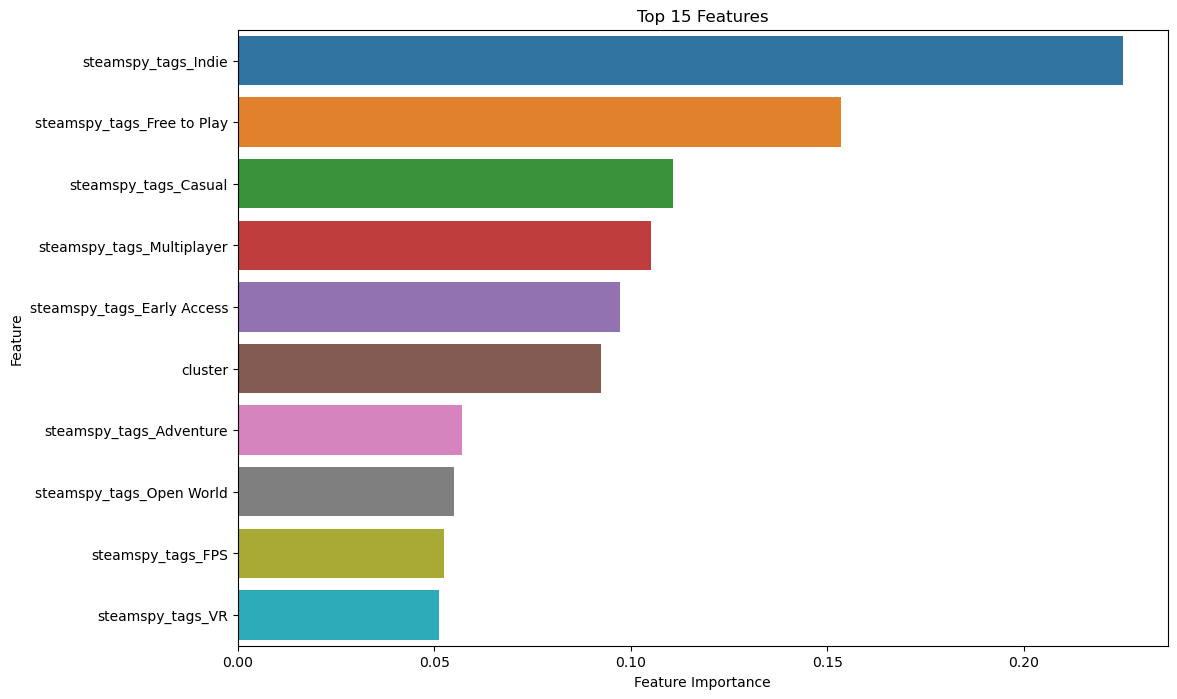

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the RandomForest model
feature_importances = selector.estimator_.feature_importances_
print(feature_importances)
print(X.columns[selector.support_].tolist())
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'feature': X.columns[selector.support_].tolist(), 'importance': feature_importances})

# Sort the DataFrame by importance values in descending order
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(data=importances_df.head(15), x='importance', y='feature', orient='h')
plt.title('Top 15 Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()


In [63]:
# Get the selected features
# selected_features = X.columns[selector.support_]

# Split the dataset using only selected features
# X_train = train_data[selected_features]
# X_test = test_data[selected_features]
# y_train = train_data['owners_midpoint_log']
# y_test = test_data['owners_midpoint_log']
X = encoded_data.drop(['appid',
                       'positive_ratings',
                       'negative_ratings',
                       'average_playtime',
                       'median_playtime',
                       'name',
                       'release_date',
                       'release_year',
                       'developer',
                       'publisher',
                       'owners_midpoint_log',
                       'achievements',
                       'price'
                      ], axis=1)
y = encoded_data['owners_midpoint_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the models with verbose monitoring
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
svm = SVR()
xgb = XGBRegressor(random_state=42, n_jobs=-1)
vr = VotingRegressor(estimators=[('rf', rf), ('svm', svm), ('xgb', xgb)], verbose=True, n_jobs=-1)

models = [rf, svm, xgb, vr]
model_names = ['Random Forest', 'SVM', 'XGBoost', 'Voting Regressor']
# model_names = ['Random Forest']
# Evaluate models using cross-validation and print results
for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f'{name} R2 score (cross-validation): {np.mean(cv_scores):.2f}')

# Fit the models on the training set and evaluate on the test set
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} - Test set: MSE = {mse:.2f}, R2 score = {r2:.2f}')
    print("Train Accuracy :", accuracy_score(y_train,y_pred))
#     print("Train Confusion Matrix :")
#     print(confusion_matrix(y_train, y_predict))
    print("Train Recall :")
    print(recall_score(y_train, y_pred))
    print("-"*50)
    #result on test:
    y_predict = dt_classifier.predict(X_test)
    print("Test Accuracy :", accuracy_score(y_test, y_pred))
    print("Test Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred))
    print("Test Recall :")
    print(recall_score(y_test, y_pred))

Random Forest R2 score (cross-validation): 0.28
SVM R2 score (cross-validation): 0.29
XGBoost R2 score (cross-validation): 0.33
Voting Regressor R2 score (cross-validation): 0.34
Random Forest - Test set: MSE = 1.09, R2 score = 0.27


ValueError: Found input variables with inconsistent numbers of samples: [17514, 7507]

In [53]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor

rf_estimator = RandomForestClassifier(n_estimators=100, random_state=1)

# rf_estimator.fit(X_train, y_train)

In [ ]:
y_pred_train_rf = rf_estimator.predict(X_train)
print(classification_report(y_train, y_pred_train_rf))

In [ ]:
y_pred_test_rf = rf_estimator.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))

In [ ]:
importances = rf_estimator.feature_importances_
print(importances)

In [ ]:
importances = rf_estimator.feature_importances_

columns = X_train.columns

importance_df = pd.DataFrame({'Feature': columns, 'Importance': importances})

plt.figure(figsize = (13, 13))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values('Importance', ascending=False))
plt.title('Feature Importances')
plt.show()